## Imports

In [1]:
# standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import time
import pickle
import math

# webscraping
import requests
from bs4 import BeautifulSoup

# stocks
import yfinance as yf

# fama french
import statsmodels.api as sm
from statsmodels import regression
from scipy.optimize import minimize
from scipy.linalg import eigh

# markowitz
from sklearn.decomposition import PCA
from TracyWidom import TracyWidom
import cvxopt as opt
from cvxopt import blas, solvers
import cufflinks
import mplfinance as mpf
import plotly.tools as tls
from plotly.graph_objs import *
solvers.options['show_progress'] = False
import rie_estimator

# ignore warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# import sys
# !{sys.executable} -m pip install rie_estimator

## Basic Goal

Plan: 
1. Data gathering
      - Randomly select 30 stocks from the S&P 500 
      - Get data for each of the stocks from the past 3 years using yfinance.  
      - Get the daily Fama-French factors from the Kenneth French website.
2. Implement the PCA Markowitz portfolio optimization
      - PCA on normalized returns
      - Check if PC1 is significant using Tracy-Widow
      - Get the portfolio that corresponds to PC1
3. Implement the Fama-French three-factor model
      - For each stock, run the standard time series regression for the Fama-French model. 
      - Get the covariance matrix from the residuals 
4. Compare the 2 portfolios against the efficient frontier

### Data Gathering

In [3]:
# getting the stocks
headers = {
    'User-Agent': (
        'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 '
        '(KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    )
}

response = requests.get(
    "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies",
    headers=headers
)
response.raise_for_status()
tables = pd.read_html(response.text)

if len(tables) > 0:
    stocks_df = tables[0]

# randomly selecting 30 stocks
random_stocks = stocks_df['Symbol'].sample(n=30, random_state=42)

In [4]:
# getting closing prices for the 30 stocks with batching
start_date = '2022-08-31'
end_date = '2025-08-31'

def download_stocks_in_batches(tickers, batch_size=5, delay=1):
    """
    Download stock data in batches to avoid rate limiting
    """
    all_data = {}
    
    for i in range(0, len(tickers), batch_size):
        batch = tickers[i:i + batch_size]
        print(f"Downloading batch {i//batch_size + 1}: {batch}")
        
        try:
            # Download the batch
            batch_data = yf.download(
                batch,
                start=start_date,
                end=end_date,
                progress=False
            )
            
            # Extract closing prices for this batch
            if not batch_data.empty and 'Close' in batch_data.columns:
                closes = batch_data['Close']
                # Handle single ticker case (returns Series instead of DataFrame)
                if isinstance(closes, pd.Series):
                    all_data[batch[0]] = closes
                else:
                    for ticker in closes.columns:
                        all_data[ticker] = closes[ticker]
                print(f"Successfully downloaded {len(batch)} stocks")
            else:
                print(f"No data returned for batch: {batch}")
            
        except Exception as e:
            print(f"Error downloading batch {batch}: {e}")
        
        # Add delay between batches to avoid rate limiting
        if i + batch_size < len(tickers):
            print(f"Waiting {delay} seconds before next batch...")
            time.sleep(delay)
    
    # Combine all data into a single DataFrame
    if all_data:
        return pd.DataFrame(all_data)
    else:
        return pd.DataFrame()

# # Download in batches of 5 stocks with 1-second delay
# closing_df = download_stocks_in_batches(
#     random_stocks.tolist(), 
#     batch_size=5, 
#     delay=15
# )

This code above was generated with ChatGPT.

In [5]:
# if not closing_df.empty:
#     closing_df.to_pickle('closing prices.pkl')

# closing_df.head(5)

In [6]:
# opening pkl file
filename = r'closing prices.pkl'
with open(filename, 'rb') as f: 
    closing_df = pickle.load(f)
    closing_df.index = pd.to_datetime(closing_df.index)

# getting s&p 500 data
filename = r'gspc prices.pkl'
with open(filename, 'rb') as f: 
    gspc_df = pickle.load(f)
    gspc_df.index = pd.to_datetime(gspc_df.index)
gspc_df.rename(columns={'^GSPC': 'GSPC'}, inplace=True)

# getting simple returns
simple_df = closing_df / closing_df.shift()
simple_df.dropna(how='all', inplace=True)

# getting log returns
log_df = np.log(simple_df)

C:\Users\Donna\AppData\Local\Temp\ipykernel_6948\1399196482.py:4: DeprecationWarning:

numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.



In [7]:
# getting fama french factors
ff_data = pd.read_csv(
    'ff_factors.csv', 
    header=3
)
ff_data.rename(columns={'Unnamed: 0': 'date'}, inplace=True)
ff_data = ff_data.iloc[:-1]

# getting dates
ff_data['date'] = ff_data['date'].astype(str).str.strip()

for idx in range(len(ff_data['date'])):
    date = ff_data.iloc[idx, 0]
    ff_data.iloc[idx, 0] = date[:4] + '-' + date[-4:-2] + '-' + date[-2:]

ff_data['date'] = pd.to_datetime(ff_data['date'])
ff_data.set_index('date', inplace=True)
ff_data = ff_data.loc[start_date:end_date]
ff_data = ff_data.iloc[1:, :]
ff_data = ff_data.apply(pd.to_numeric, errors='coerce')
ff_data

,Mkt-RF,SMB,HML,RF
date,,,,
2022-09-01,0.00,-1.11,-0.28,0.01
2022-09-02,-0.99,-0.06,1.03,0.01
2022-09-06,-0.51,-0.45,-0.54,0.01
2022-09-07,1.92,0.71,-1.53,0.01
2022-09-08,0.78,-0.08,-0.18,0.01
...,...,...,...,...
2025-08-25,-0.48,-0.63,0.45,0.02
2025-08-26,0.43,0.25,0.13,0.02
2025-08-27,0.24,0.40,0.27,0.02


### Implement the PCA Markowitz portfolio optimization

In [8]:
returns_df = simple_df.pct_change().dropna()

# Normalize returns
norm_returns = (returns_df - returns_df.mean()) / returns_df.std()

# Group by 12-month periods starting in August
fiscal_year = returns_df.index.to_period('M').to_timestamp()
fiscal_year = fiscal_year - pd.DateOffset(months=7)  # shift so Aug is start of year
fiscal_year = fiscal_year.year

returns_df = returns_df.groupby(fiscal_year)
norm_returns = norm_returns.groupby(fiscal_year)

In [9]:
def do_pca_markowitz_on_year(returns_df, year):  # Change parameter to returns_df
    # Use raw returns, just center them
    year_returns = returns_df.get_group(year)
    centered_returns = year_returns - year_returns.mean()
    
    # --- Fit PCA on centered returns ---
    pca = PCA().fit(centered_returns)
    eigs = pca.explained_variance_        # eigenvalues (variances of each PC)

    # --- Get n (samples) and p (features) ---
    n, p = centered_returns.shape

    # --- Tracy–Widom scaling (Johnstone 2001) ---
    sqrt_n = np.sqrt(n)
    sqrt_p = np.sqrt(p)
    mu = (sqrt_n + sqrt_p)**2 / n
    sigma = (sqrt_n + sqrt_p) * (1/sqrt_n + 1/sqrt_p)**(1/3) / n

    # --- Convert sklearn's (1/(n-1)) scaling to 1/n convention ---
    lambda1 = eigs[0] * (n - 1) / n

    # --- Compute TW statistic and p-value ---
    tw_stat = (lambda1 - mu) / sigma
    tw = TracyWidom(beta=1)
    pval = 1 - tw.cdf(tw_stat)

    print(f"Largest eigenvalue: {lambda1:.5f}")
    print(f"Tracy–Widom statistic: {tw_stat:.5f}")
    print(f"p-value: {pval:.5e}")

    return pca

def get_pca_portfolios(year, num_components=5, returns_df=returns_df):
    """Use raw returns for PCA with proper portfolio scaling"""
    
    # Use raw returns for PCA, just center them
    year_returns = returns_df.get_group(year)
    centered_returns = year_returns - year_returns.mean()
    
    # Fit PCA on centered returns
    pca = PCA().fit(centered_returns)
    
    pcs = []
    for i in range(num_components):
        # Get PC weights
        pc_weights = pca.components_[i]
        
        # Create portfolio with proper scaling
        pc_portfolio = pd.Series(pc_weights, index=year_returns.columns)
        
        # Normalize to have unit L2 norm (like PCA components naturally have)
        pc_portfolio = pc_portfolio / np.linalg.norm(pc_portfolio)
        
        pc_portfolio.name = f"PC {i+1}"
        pcs.append(pc_portfolio)
    
    return pcs

def calculate_pc_sharpe_ratios(year, returns_df=returns_df):
    """Calculate actual Sharpe ratios for PC portfolios with stability checks"""
    year_returns = returns_df.get_group(year)
    centered_returns = year_returns - year_returns.mean()
    
    # Fit PCA on centered returns
    pca = PCA().fit(centered_returns)
    
    sharpe_ratios = []
    for i in range(len(pca.components_)):
        weights = pca.components_[i]
        
        # Normalize weights to unit L2 norm
        weights = weights / np.linalg.norm(weights)
        
        # Portfolio returns
        portfolio_returns = year_returns @ weights
        
        # Avoid division by zero
        portfolio_std = portfolio_returns.std()
        if portfolio_std < 1e-10:  # Near zero standard deviation
            sharpe = 0.0
        else:
            sharpe = portfolio_returns.mean() / portfolio_std
        
        sharpe_ratios.append(sharpe)
        
        print(f"PC {i+1}: Sharpe = {sharpe:.3f}, Mean = {portfolio_returns.mean():.6f}, Std = {portfolio_std:.6f}")
    
    return sharpe_ratios

def analyze_pca_variance(year, returns_df=returns_df):
    """Analyze how much variance each PC explains"""
    year_returns = returns_df.get_group(year)
    centered_returns = year_returns - year_returns.mean()
    
    pca = PCA().fit(centered_returns)
    
    print(f"\n=== Variance Analysis for {year} ===")
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance_ratio)
    
    for i in range(min(10, len(explained_variance_ratio))):
        print(f"PC {i+1}: {explained_variance_ratio[i]:.3f} ({cumulative_variance[i]:.3f} cumulative)")

In [10]:
pcs_2022 = get_pca_portfolios(2022,2)

In [11]:
def plot_portfolios_vs_random(returns_df, years, approaches, max_risk=0.25, title=None, *args, **kwargs):
    """
    Plots expected return vs risk for random portfolios and given approaches portfolios.

    Parameters:
    - returns_df: DataFrame with MultiIndex (year, asset) and returns values.
    - years: list of years to plot.
    - approaches: either a list of DataFrames/Series (portfolios) or a function(**kwargs) -> list of portfolios.
    - max_risk: maximum standard deviation to filter random portfolios.
    - title: optional string, used as the super-title for the entire multiplot.
    - *args, **kwargs: optional arguments forwarded to approaches(**kwargs) if approaches is callable.
                       'year' is automatically added as a keyword argument for each year.
    """
    if isinstance(years, int):
        years = [years]

    n_years = len(years)
    n_cols = math.ceil(math.sqrt(n_years))
    n_rows = math.ceil(n_years / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
    axes = np.array(axes).reshape(-1)  # flatten in case of single row/col

    for i, year in enumerate(years):
        ax = axes[i]

        # --- Compute mean returns and covariance ---
        mean_returns = returns_df.get_group(year).mean()
        cov_matrix = returns_df.get_group(year).cov()
        n_assets = len(mean_returns)

        # --- Generate random portfolios using normalized Gaussian weights ---
        raw_weights = np.random.randn(90000, n_assets)
        weights = raw_weights / raw_weights.sum(axis=1, keepdims=True)

        # Expected returns of each portfolio
        returns = weights @ mean_returns.values

        # Portfolio variances and standard deviations
        portfolio_vars = np.sum(weights @ cov_matrix.values * weights, axis=1)
        risks = np.sqrt(portfolio_vars)

        # --- Filter random portfolios by max risk ---
        mask = risks <= max_risk
        filtered_returns = returns[mask]
        filtered_risks = risks[mask]

        # --- Plot random portfolios ---
        sc = ax.scatter(filtered_risks, filtered_returns, c=filtered_returns/filtered_risks,
                        cmap='viridis', s=10, alpha=0.5, label='Random Portfolios')
        plt.colorbar(sc, ax=ax, label='Sharpe Ratio (Return/Risk)')

        # --- Determine approaches portfolios for this year ---
        if callable(approaches):
            current_kwargs = dict(kwargs)
            current_kwargs['year'] = year  # automatically pass the year as a keyword
            current_approaches = approaches(*args, **current_kwargs)
        else:
            current_approaches = approaches

        # --- Plot approaches portfolios ---
        for j, approach in enumerate(current_approaches):
            w = approach.reindex(mean_returns.index).fillna(0).values
            ret = np.dot(w, mean_returns.values)
            risk = np.sqrt(np.dot(w.T, np.dot(cov_matrix.values, w)))

            label = approach.name if hasattr(approach, 'name') and approach.name else f'Portfolio {j+1}'

            ax.scatter(risk, ret, color='red', s=60, edgecolors='black', zorder=5)
            ax.text(risk, ret, label, fontsize=9, ha='left', va='bottom')

        ax.set_title(f'Year {year}\nMax σ ≤ {max_risk:.3f}')
        ax.set_xlabel('Risk (Standard Deviation)')
        ax.set_ylabel('Expected Return (Mean)')
        ax.grid(True, linestyle='--', alpha=0.7)

    # Remove empty subplots if any
    for j in range(i+1, n_rows*n_cols):
        fig.delaxes(axes[j])

    if title is not None:
        fig.suptitle(title, fontsize=16, y=1.02)

    plt.tight_layout()
    plt.show()


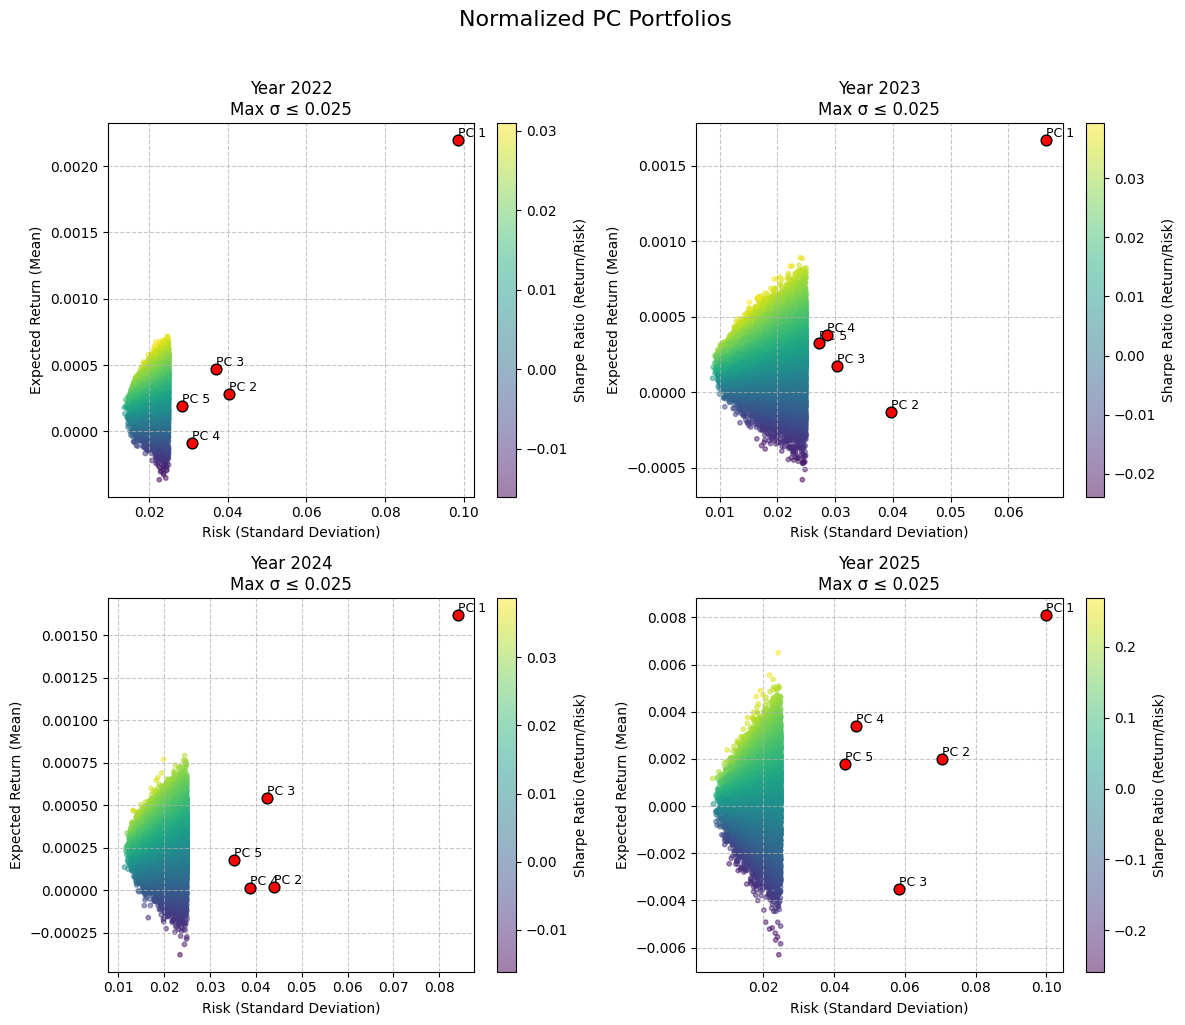

In [12]:
plot_portfolios_vs_random(
    returns_df, [2022, 2023, 2024, 2025], get_pca_portfolios, 
    max_risk=0.025, title = "Normalized PC Portfolios", 
    # indeces = 1
)

In [13]:
def plot_sharpe_over_years_fixed(returns_df, years, approaches, n_random=500_000, seed=None):
    """
    Plots Sharpe ratio over years for fixed approaches portfolios and
    a single random portfolio selected as the max-Sharpe portfolio in year 1.

    Parameters:
    - returns_df: DataFrameGroupBy object grouped by year
    - years: list of years to plot
    - approaches: list of fixed portfolios (Series/DataFrames)
    - n_random: number of random portfolios to generate
    - seed: random seed for reproducibility
    """
    if isinstance(years, int):
        years = [years]

    first_year = years[0]

    # --- Generate random portfolios for first year ---
    mean_returns = returns_df.get_group(first_year).mean()
    cov_matrix = returns_df.get_group(first_year).cov()
    n_assets = len(mean_returns)

    if seed is not None:
        np.random.seed(seed)

    raw_weights = np.random.randn(n_random, n_assets)
    weights = raw_weights / raw_weights.sum(axis=1, keepdims=True)

    # Portfolio returns and risks
    rets = weights @ mean_returns.values
    risks = np.sqrt(np.sum(weights @ cov_matrix.values * weights, axis=1))
    sharpes = rets / risks

    # --- Pick the portfolio with the max Sharpe ---
    max_idx = np.argmax(sharpes)
    best_random_w = weights[max_idx]

    # --- Storage for tracking ---
    approaches_sharpes = {i: [] for i in range(len(approaches))}
    random_sharpe_over_years = []

    for year in years:
        mean_returns = returns_df.get_group(year).mean()
        cov_matrix = returns_df.get_group(year).cov()

        # Track max-Sharpe random portfolio
        ret = np.dot(best_random_w, mean_returns.values)
        risk = np.sqrt(np.dot(best_random_w.T, np.dot(cov_matrix.values, best_random_w)))
        random_sharpe_over_years.append(ret / risk)

        # Track approaches portfolios
        for j, approach in enumerate(approaches):
            w = approach.reindex(mean_returns.index).fillna(0).values
            ret = np.dot(w, mean_returns.values)
            risk = np.sqrt(np.dot(w.T, np.dot(cov_matrix.values, w)))
            sharpe = ret / risk
            approaches_sharpes[j].append(sharpe)

    # --- Plotting ---
    plt.figure(figsize=(10, 6))

    # Random max-Sharpe portfolio
    plt.plot(years, random_sharpe_over_years, marker='o', linestyle='--', color='black', label='Max-Sharpe Random (Year 1)')

    # Approaches portfolios
    for j, sharpe_list in approaches_sharpes.items():
        label = approaches[j].name if hasattr(approaches[j], 'name') and approaches[j].name else f'Approach {j+1}'
        plt.plot(years, sharpe_list, marker='s', linestyle='-', label=label, color=f'C{j}')

    plt.title('Sharpe Ratio Over Years (Including Max-Sharpe Random Portfolio)')
    plt.xlabel('Year')
    plt.ylabel('Sharpe Ratio (Return / Risk)')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()


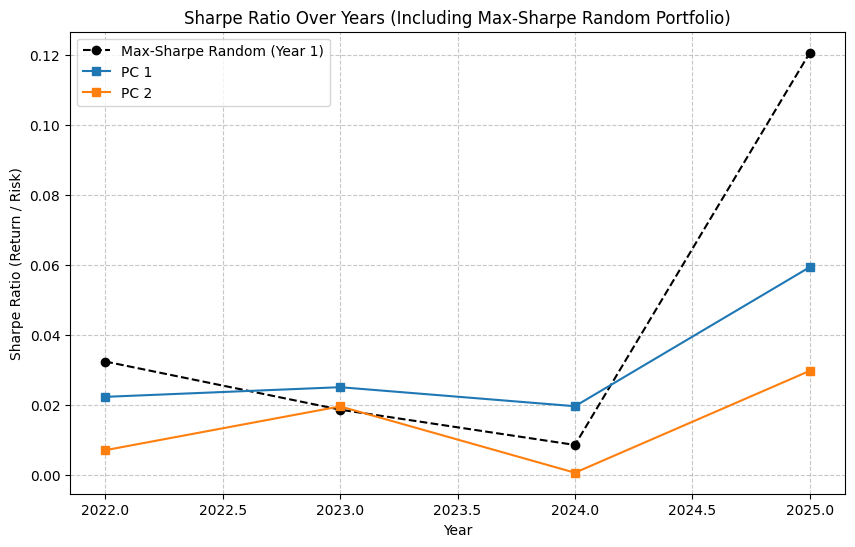

In [14]:
plot_sharpe_over_years_fixed(
    returns_df, [2022,2023,2024,2025], pcs_2022
)

### Donna's PCA Markowitz portfolio optimization

In [15]:
def get_portfolio(closing_df):
    # get returns of covariance matrix
    returns_df = closing_df.pct_change().dropna()
    centered_returns = returns_df - returns_df.mean() # mean centering
    columns = returns_df.columns

    # apply pca
    pca = PCA()
    returns_pca = pca.fit_transform(centered_returns)
    returns_pca = pd.DataFrame(
        returns_pca, 
        columns=[f"PC{i+1}" for i in range(returns_pca.shape[1])],
        index=returns_df.index
    )

    # Get portfolio weights from PCA components
    portfolio_weights = pd.DataFrame(
        pca.components_.T,
        index=columns,
        columns=[f"PC{i+1}" for i in range(pca.components_.shape[0])]
    )
    
    # get portfolios
    mp = portfolio_weights['PC1']
    other_portfolios = portfolio_weights.iloc[:, 1:]
        
    return mp, other_portfolios

In [16]:
def get_sharpe(rx, stdev, start_date, end_date):
    rf = ff_data.loc[start_date:end_date, 'RF'].mean()
    return (rx - rf) / stdev 
    
def plot_portfolios(portfolios, start_date, end_date, max_risk=0.3):
    raw_returns = closing_df.loc[start_date:end_date].pct_change().dropna()
    gspc_returns = gspc_df.loc[start_date:end_date].pct_change().dropna()
    
    # creating mean returns and covariance
    mean_returns = raw_returns.mean()
    cov_matrix = raw_returns.cov()
    n_assets = len(mean_returns)

    # plotting
    fig, ax = plt.subplots(figsize=(10, 6))

    # generate random portfolios
    raw_weights = np.random.randn(100000, n_assets)
    weights = raw_weights / raw_weights.sum(axis=1, keepdims=True)
    returns = weights @ mean_returns.values

    # portfolio variances and standard deviations
    portfolio_vars = np.sum(weights @ cov_matrix.values * weights, axis=1)
    risks = np.sqrt(portfolio_vars)
    
    # filter by max risk if specified
    if max_risk is not None:
        mask = risks <= max_risk
        filtered_returns = returns[mask]
        filtered_risks = risks[mask]
    else:
        filtered_returns = returns
        filtered_risks = risks

    # getting sharpe ratio
    sharpe_ratio_random = (filtered_returns - ff_data.loc[start_date:end_date, 'RF'].mean()) / filtered_risks
    
    # plot random portfolios
    sc = ax.scatter(filtered_risks, filtered_returns, c=filtered_returns/filtered_risks,
                    cmap='viridis', s=10, alpha=0.5, label='Random Portfolios')
    plt.colorbar(sc, ax=ax, label='Sharpe Ratio (Return/Risk)')

    # plot gspc portfolio
    

    # plot portfolios
    for i, portfolio in enumerate(portfolios):
        # Get portfolio weights aligned with current assets
        portfolio_weights = portfolio.reindex(mean_returns.index).fillna(0).values
        
        # Calculate portfolio return and risk
        portfolio_return = np.dot(portfolio_weights, mean_returns.values)
        portfolio_risk = np.sqrt(np.dot(portfolio_weights.T, np.dot(cov_matrix.values, portfolio_weights)))
        portfolio_sharpe = get_sharpe(portfolio_return, portfolio_risk, start_date, end_date)
        
        # Plot the portfolio
        label = portfolio.name if hasattr(portfolio, 'name') else f'Portfolio {i+1}'
        ax.scatter(portfolio_risk, portfolio_return, color='red', s=100, edgecolors='black', zorder=5)
        ax.text(portfolio_risk, portfolio_return, f'{label}', 
                fontsize=9, ha='left', va='bottom')

    ax.set_title(f'Period {str(start_date).split()[0]} to {str(end_date).split()[0]}\nMax σ ≤ {max_risk:.3f}')
    ax.set_xlabel('Risk (Standard Deviation)')
    ax.set_ylabel('Expected Return (Mean)')
    ax.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [51]:
year = 2024
start_date = f'{int(year) - 1}-08-29'
end_date = f'{int(year)}-08-29'

df = gspc_df.loc[start_date:end_date].pct_change().dropna()
rf_daily = (ff_data.loc[df.index, 'RF'] / 100 / len(df.index))
excess_returns = df['GSPC'] - rf_daily.values
sharpe_ratio = (excess_returns.mean() / excess_returns.std()) * np.sqrt(len(df.index))

print(sharpe_ratio)

1.8212037144811524


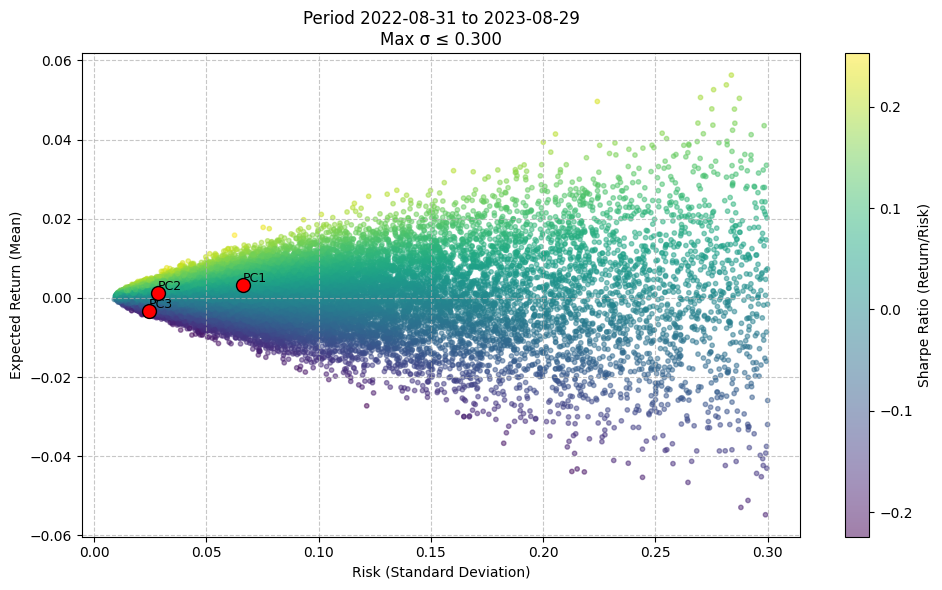

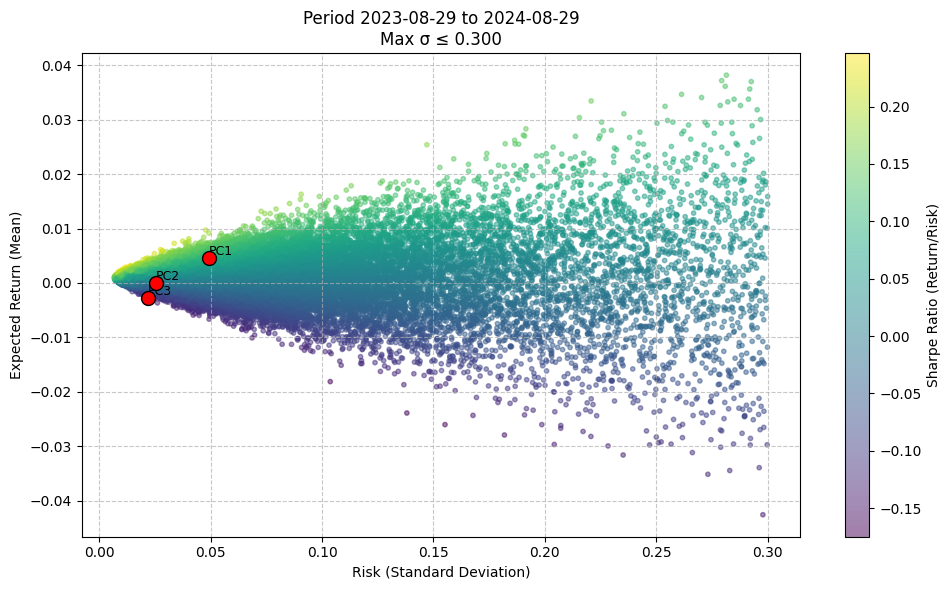

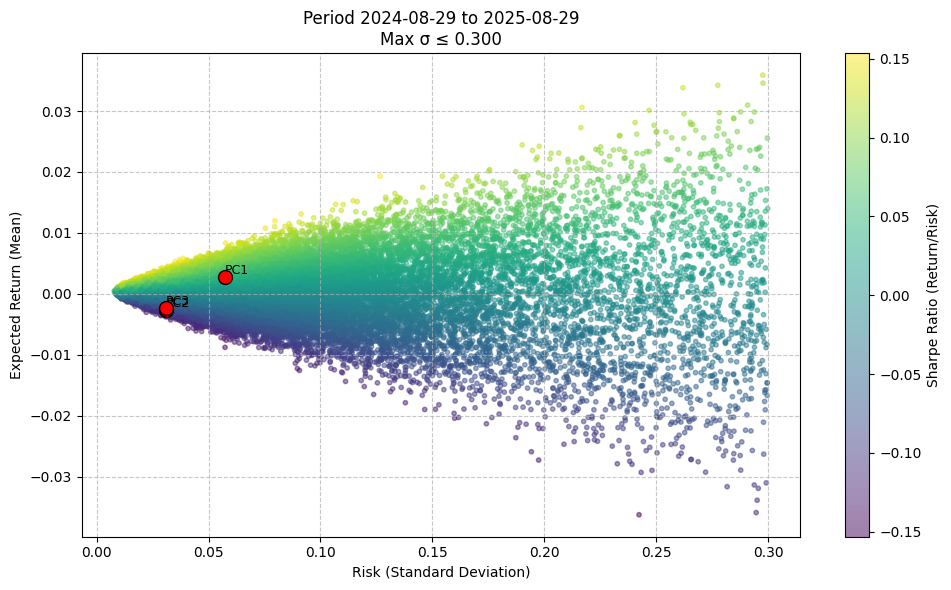

In [24]:
years = ['2023', '2024', '2025']

for year in years:
    # getting portfolios
    if year == '2023':
        start_date = closing_df.index[0]
        end_date = f'{year}-08-29'
        mp, portfolios = get_portfolio(closing_df.loc[start_date:end_date])
    else:
        start_date = f'{int(year) - 1}-08-29'
        end_date = f'{int(year)}-08-29'
        mp, portfolios = get_portfolio(closing_df.loc[start_date:end_date])
    
    # plotting portfolios
    plot_portfolios(
        [mp, portfolios.iloc[:, 0], portfolios.iloc[:, 1]], 
        start_date=start_date, end_date=end_date
    )

### Implement the Fama-French three-factor model

In [18]:
# code generated with ChatGPT
def min_idiosyncratic_risk_portfolio(residual_cov_matrix, method='long_only'):
    """
    Construct portfolio that minimizes idiosyncratic risk
    
    Parameters:
    -----------
    residual_cov_matrix : array-like
        Covariance matrix of Fama-French residuals (N x N)
    method : str
        'long_only' - no short selling, weights sum to 1
        'fully_invested' - can short, weights sum to 1  
        'dollar_neutral' - long/short, weights sum to 0
    """
    N = residual_cov_matrix.shape[0]
    
    if method == 'long_only':
        # No short selling constraint
        constraints = [
            {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # Sum to 1
        ]
        bounds = [(0, 1) for _ in range(N)]  # No short selling
        
    elif method == 'fully_invested':
        # Can short, but fully invested
        constraints = [
            {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
        ]
        bounds = [(-1, 1) for _ in range(N)]
        
    elif method == 'dollar_neutral':
        # Dollar neutral (long/short)
        constraints = [
            {'type': 'eq', 'fun': lambda x: np.sum(x)},  # Sum to 0
            {'type': 'eq', 'fun': lambda x: np.sum(np.abs(x)) - 1},  # Total leverage = 1
        ]
        bounds = [(-1, 1) for _ in range(N)]
    
    # Objective function: portfolio variance = w'Σw
    def objective(weights):
        return weights.T @ residual_cov_matrix @ weights
    
    # Initial guess (equal weights)
    x0 = np.ones(N) / N
    
    # Optimize
    result = minimize(objective, x0, method='SLSQP', 
                     bounds=bounds, constraints=constraints)
    
    return result.x, result.fun

def idiosyncratic_risk_parity(residual_cov_matrix):
    """
    Risk parity portfolio based on idiosyncratic risk
    Each asset contributes equally to portfolio idiosyncratic risk
    """
    # Get idiosyncratic variances (diagonal of covariance matrix)
    idiosyncratic_variances = np.diag(residual_cov_matrix)
    
    # Risk parity weights: inverse of standard deviation
    weights = 1 / np.sqrt(idiosyncratic_variances)
    weights = weights / np.sum(weights)  # Normalize
    
    # Calculate portfolio idiosyncratic risk
    portfolio_variance = weights.T @ residual_cov_matrix @ weights
    
    return weights, np.sqrt(portfolio_variance)

def max_diversification_residuals(residual_cov_matrix):
    """
    Maximum diversification portfolio using residual covariance matrix
    Maximizes the diversification ratio: weighted avg vol / portfolio vol
    """
    N = residual_cov_matrix.shape[0]
    
    # Individual idiosyncratic volatilities
    idiosyncratic_vols = np.sqrt(np.diag(residual_cov_matrix))
    
    def diversification_ratio(weights):
        portfolio_vol = np.sqrt(weights.T @ residual_cov_matrix @ weights)
        weighted_avg_vol = weights @ idiosyncratic_vols
        return weighted_avg_vol / portfolio_vol
    
    # Constraints: long only, fully invested
    constraints = [
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
    ]
    bounds = [(0, 1) for _ in range(N)]
    
    # Negative because we maximize
    def objective(weights):
        return -diversification_ratio(weights)
    
    x0 = np.ones(N) / N
    result = minimize(objective, x0, method='SLSQP', 
                     bounds=bounds, constraints=constraints)
    
    return result.x, -result.fun

def construct_residual_based_portfolio(ff_residuals_cov, expected_returns=None, 
                                     target_return=None, method='min_risk'):
    """
    Complete portfolio construction from Fama-French residuals covariance
    
    Parameters:
    -----------
    ff_residuals_cov : DataFrame
        Covariance matrix of Fama-French residuals
    expected_returns : array-like, optional
        Expected returns for mean-variance optimization
    target_return : float, optional  
        Target return for mean-variance optimization
    method : str
        'min_risk' - minimum idiosyncratic risk
        'risk_parity' - risk parity on residuals
        'max_diversification' - maximum diversification
        'mean_variance' - traditional mean-variance on residuals
    """
    
    cov_matrix = ff_residuals_cov.values
    stocks = ff_residuals_cov.columns.tolist()
    N = len(stocks)
    
    if method == 'min_risk':
        weights, risk = min_idiosyncratic_risk_portfolio(cov_matrix, 'long_only')
        
    elif method == 'risk_parity':
        weights, risk = idiosyncratic_risk_parity(cov_matrix)
        
    elif method == 'max_diversification':
        weights, risk = max_diversification_residuals(cov_matrix)
        
    elif method == 'mean_variance':
        if expected_returns is None:
            raise ValueError("Expected returns required for mean-variance optimization")
        if target_return is None:
            target_return = np.mean(expected_returns)
        
        weights, risk = mean_variance_residuals(cov_matrix, expected_returns, target_return)
    
    # Create portfolio series
    portfolio = pd.Series(weights, index=stocks, name='Weights')
    
    # Calculate portfolio statistics
    portfolio_variance = weights.T @ cov_matrix @ weights
    portfolio_volatility = np.sqrt(portfolio_variance)
    
    if expected_returns is not None:
        portfolio_return = weights @ expected_returns
    else:
        portfolio_return = None
    
    results = {
        'weights': portfolio,
        'idiosyncratic_volatility': portfolio_volatility,
        'expected_return': portfolio_return,
        'method': method
    }
    
    return results

def mean_variance_residuals(residual_cov_matrix, expected_returns, target_return):
    """
    Mean-variance optimization using residual covariance matrix
    """
    N = residual_cov_matrix.shape[0]
    
    # Objective: minimize portfolio variance
    def objective(weights):
        return weights.T @ residual_cov_matrix @ weights
    
    # Constraints
    constraints = [
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # Fully invested
        {'type': 'eq', 'fun': lambda x: x @ expected_returns - target_return},  # Target return
    ]
    
    bounds = [(0, 1) for _ in range(N)]  # Long only
    
    x0 = np.ones(N) / N
    result = minimize(objective, x0, method='SLSQP', 
                     bounds=bounds, constraints=constraints)
    
    portfolio_variance = result.x.T @ residual_cov_matrix @ result.x
    
    return result.x, np.sqrt(portfolio_variance)

def construct_residual_based_portfolio(ff_residuals_cov, expected_returns=None, 
                                     target_return=None, method='min_risk'):
    """
    Complete portfolio construction from Fama-French residuals covariance
    
    Parameters:
    -----------
    ff_residuals_cov : DataFrame
        Covariance matrix of Fama-French residuals
    expected_returns : array-like, optional
        Expected returns for mean-variance optimization
    target_return : float, optional  
        Target return for mean-variance optimization
    method : str
        'min_risk' - minimum idiosyncratic risk
        'risk_parity' - risk parity on residuals
        'max_diversification' - maximum diversification
        'mean_variance' - traditional mean-variance on residuals
    """
    
    cov_matrix = ff_residuals_cov.values
    stocks = ff_residuals_cov.columns.tolist()
    N = len(stocks)
    
    if method == 'min_risk':
        weights, risk = min_idiosyncratic_risk_portfolio(cov_matrix, 'long_only')
        
    elif method == 'risk_parity':
        weights, risk = idiosyncratic_risk_parity(cov_matrix)
        
    elif method == 'max_diversification':
        weights, risk = max_diversification_residuals(cov_matrix)
        
    elif method == 'mean_variance':
        if expected_returns is None:
            raise ValueError("Expected returns required for mean-variance optimization")
        if target_return is None:
            target_return = np.mean(expected_returns)
        
        weights, risk = mean_variance_residuals(cov_matrix, expected_returns, target_return)
    
    # Create portfolio series
    portfolio = pd.Series(weights, index=stocks, name='Weights')
    
    # Calculate portfolio statistics
    portfolio_variance = weights.T @ cov_matrix @ weights
    portfolio_volatility = np.sqrt(portfolio_variance)
    
    if expected_returns is not None:
        portfolio_return = weights @ expected_returns
    else:
        portfolio_return = None
    
    results = {
        'weights': portfolio,
        'idiosyncratic_volatility': portfolio_volatility,
        'expected_return': portfolio_return,
        'method': method
    }
    
    return results

def mean_variance_residuals(residual_cov_matrix, expected_returns, target_return):
    """
    Mean-variance optimization using residual covariance matrix
    """
    N = residual_cov_matrix.shape[0]
    
    # Objective: minimize portfolio variance
    def objective(weights):
        return weights.T @ residual_cov_matrix @ weights
    
    # Constraints
    constraints = [
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # Fully invested
        {'type': 'eq', 'fun': lambda x: x @ expected_returns - target_return},  # Target return
    ]
    
    bounds = [(0, 1) for _ in range(N)]  # Long only
    
    x0 = np.ones(N) / N
    result = minimize(objective, x0, method='SLSQP', 
                     bounds=bounds, constraints=constraints)
    
    portfolio_variance = result.x.T @ residual_cov_matrix @ result.x
    
    return result.x, np.sqrt(portfolio_variance)

In [19]:
# get excess returns for each stock 
excess_returns = simple_df.sub(ff_data['RF'], axis=0)
excess_returns.head()

# get factors 
factors = ff_data.iloc[:, :3]

# get residuals
residuals_df = pd.DataFrame(index=excess_returns.index)
for stock in excess_returns.columns:
    y = excess_returns[stock].dropna()
    x = factors.loc[y.index]

    x_const = sm.add_constant(x)
    model = sm.OLS(y, x_const).fit()
    residuals_df[stock] = model.resid

# get covariance matrix of the residuals
residuals_clean = residuals_df.dropna(axis=1)
covariance_matrix = residuals_clean.cov()

# get a portfolio
portfolio = construct_residual_based_portfolio(
    covariance_matrix,
    method='risk_parity'
)

# check portfolio
print("\nRisk Parity Portfolio:")
print(portfolio['weights'].sort_values(ascending=False).head(10))
print(f"Idiosyncratic Volatility: {portfolio['idiosyncratic_volatility']:.4f}")


Risk Parity Portfolio:
ROP     0.047048
LIN     0.044330
AMP     0.042982
PNC     0.042852
CB      0.040140
BR      0.040132
O       0.039558
FITB    0.039160
XYL     0.037294
MAA     0.036477
Name: Weights, dtype: float64
Idiosyncratic Volatility: 0.0050


In [20]:
ff = portfolio['weights']
ff

BR      0.040132
CINF    0.035561
DHI     0.023789
K       0.036109
LIN     0.044330
BA      0.023810
GLW     0.031996
IDXX    0.023808
LHX     0.034063
O       0.039558
A       0.030214
CAH     0.033297
FITB    0.039160
MTCH    0.019660
PNC     0.042852
AMP     0.042982
MAA     0.036477
RJF     0.035944
SBAC    0.026328
XYL     0.037294
BLDR    0.020274
HCA     0.029116
HSIC    0.030813
WMB     0.036377
WTW     0.035704
CB      0.040140
NWS     0.036274
ROP     0.047048
UNH     0.021485
VTRS    0.025406
Name: Weights, dtype: float64

## Intermediate Goal

Plan:
1. Implement the RIE Markowitz portfolio optimization
      - Estimate the covariance matrix by doing RIE on the log returns
2. Check which eigenvectors are significant using Marchenco-Pastur and pick one to use for the portfolio (this should be the second largest eigenvalue).
3. Compare its fit to the efficient frontier.

### Implement the RIE Markowitz portfolio optimization

In [21]:
def compute_RIE_eig_on_year(norm_returns, year):
    # compute RIE-cleaned correlation matrix
    cleansed_rie = rie_estimator.get_rie(norm_returns.get_group(year), normalize=True, max_ones=True)

    # eigen-decomposition
    eigvals, eigvecs = np.linalg.eigh(cleansed_rie)
    eigvals = np.real(eigvals)
    return eigvals, eigvecs

eigvals, eigvecs = compute_RIE_eig_on_year(norm_returns, 2022)

### Check which eigenvectors are significant using Marchenco-Pastur and pick one to use for the portfolio

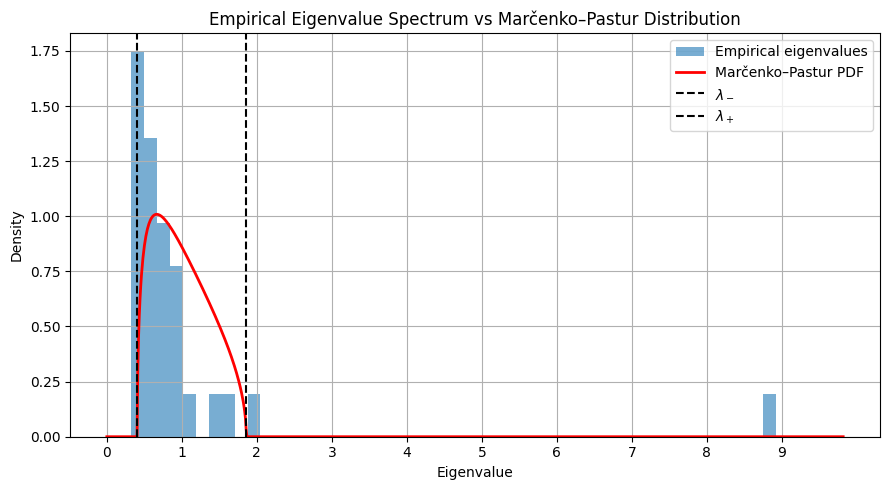

Number of significant eigenvalues: 2
Significant eigenvalues:
[1.90955167 8.9248708 ]

Shape of corresponding eigenvector matrix: (30, 2)
(Columns correspond to significant principal components.)

First significant eigenvector:
[-0.21618052  0.15366579 -0.18077115 -0.12400418  0.03480048  0.18741149
 -0.04716226 -0.25248204  0.099755   -0.16396212 -0.17316259  0.1204162
  0.31916552  0.0212873   0.25593649  0.21011259 -0.12796514  0.3481406
 -0.29207811 -0.09044719  0.00257354 -0.23114462 -0.19992449  0.10898288
 -0.0249312   0.2396004   0.1568003  -0.24764194  0.05126321 -0.05551506]


In [22]:
def do_marchenco(eigvals, eigvecs, year):
    # Marčenko–Pastur parameters
    T, N = norm_returns.get_group(year).shape
    q = N / T
    lambda_minus = (1 - np.sqrt(q))**2
    lambda_plus = (1 + np.sqrt(q))**2

    # Define MP PDF
    def mp_pdf(lmbda, q):
        lm, lp = (1 - np.sqrt(q))**2, (1 + np.sqrt(q))**2
        pdf = np.zeros_like(lmbda)
        mask = (lmbda >= lm) & (lmbda <= lp)
        pdf[mask] = np.sqrt((lp - lmbda[mask]) * (lmbda[mask] - lm)) / (2 * np.pi * q * lmbda[mask])
        return pdf

    lambda_grid = np.linspace(0, max(eigvals) * 1.1, 1000)
    mp_density = mp_pdf(lambda_grid, q)

    # plotting
    plt.figure(figsize=(9, 5))
    plt.hist(eigvals, bins=50, density=True, alpha=0.6, label='Empirical eigenvalues')
    plt.plot(lambda_grid, mp_density, 'r-', lw=2, label='Marčenko–Pastur PDF')
    plt.axvline(lambda_minus, color='k', linestyle='--', label=r'$\lambda_-$')
    plt.axvline(lambda_plus, color='k', linestyle='--', label=r'$\lambda_+$')

    plt.title('Empirical Eigenvalue Spectrum vs Marčenko–Pastur Distribution')
    plt.xlabel('Eigenvalue')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)

    # force x-axis ticks to integer alignment
    max_tick = int(np.ceil(max(eigvals)))
    plt.xticks(np.arange(0, max_tick + 1, 1))

    plt.tight_layout()
    plt.show()

    # identify significant eigenvalues (above the MP upper bound)
    significant_mask = eigvals > lambda_plus

    # extract those eigenvalues and their corresponding eigenvectors
    significant_eigvals = eigvals[significant_mask]
    significant_eigvecs = eigvecs[:, significant_mask]

    print(f"Number of significant eigenvalues: {significant_eigvals.size}")
    print("Significant eigenvalues:")
    print(significant_eigvals)

    print("\nShape of corresponding eigenvector matrix:", significant_eigvecs.shape)
    print("(Columns correspond to significant principal components.)")

    # inspect first significant eigenvector
    if significant_eigvals.size > 0:
        print("\nFirst significant eigenvector:")
        print(significant_eigvecs[:, 0])
    return significant_eigvecs

significant_eigvecs = do_marchenco(eigvals, eigvecs, 2022)

In [23]:
# Assuming norm_returns is your DataFrame (T x N) with stock names as columns
stock_names = norm_returns.get_group(2022).columns

v = significant_eigvecs

# Compute squared, normalized weights
weights_sq = v**2 / np.sum(v**2)

pc1_sq_weights = pd.DataFrame({
    'Stock': stock_names,
    'Weight': weights_sq
})

pc1_sq_series = pd.Series(data=pc1_sq_weights['Weight'].values,
                          index=pc1_sq_weights['Stock'],
                          name='Weight')


ValueError: Per-column arrays must each be 1-dimensional

In [ ]:
pc1_sq_series

### Compare its fit to the efficient frontier.

In [ ]:
# --- Inputs ---
pc0.name = "PC0"
pc1.name = "PC1"

approaches = [pc0, pc1, pc1_sq_series]
stdev_range = (0.001, 0.1)

# --- Compute mean returns and covariance ---
mean_returns = returns_df.get_group(2022).mean()
cov_matrix = returns_df.get_group(2022).cov()
n_assets = len(mean_returns)

# --- Generate random portfolios using normalized Gaussian weights ---
n_portfolios = 90000
raw_weights = np.random.randn(n_portfolios, n_assets)   # Gaussian draws
weights = raw_weights / raw_weights.sum(axis=1, keepdims=True)

# Expected returns of each portfolio
returns = weights @ mean_returns.values


# Portfolio variances and standard deviations
portfolio_vars = np.sum(weights @ cov_matrix.values * weights, axis=1)
risks = np.sqrt(portfolio_vars)

# --- Filter random portfolios by stdev ---
mask = (risks >= stdev_range[0]) & (risks <= stdev_range[1])
filtered_returns = returns[mask]
filtered_risks = risks[mask]

# --- Plot random portfolios ---
plt.figure(figsize=(10, 7))
plt.scatter(filtered_risks, filtered_returns, c=filtered_returns/filtered_risks,
            cmap='viridis', s=10, alpha=0.5, label='Random Portfolios')
plt.colorbar(label='Sharpe Ratio (Return/Risk)')

# --- Plot approaches portfolios (all, unfiltered) ---
for i, approach in enumerate(approaches):
    w = approach.reindex(mean_returns.index).fillna(0).values
    ret = np.dot(w, mean_returns.values)
    risk = np.sqrt(np.dot(w.T, np.dot(cov_matrix.values, w)))
    
    label = approach.name if approach.name else f'Portfolio {i+1}'
    
    plt.scatter(risk, ret, color='red', s=60, edgecolors='black', zorder=5)
    plt.text(risk, ret, label, fontsize=9, ha='left', va='bottom')

plt.title(f'Expected Return vs Risk (with Theoretical Frontier)\nFiltered {stdev_range[0]:.3f} ≤ σ ≤ {stdev_range[1]:.3f}')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Expected Return (Mean)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


In [ ]:
mean_returns.mean()

## Advanced Goal

Plan:
As per the study done by Molero-Gonzales et al., (2023), the steps we will follow are the ff:
1. Apply the Fama-French 3 Factor Model on the log returns matrix.
2. Turn the coefficients for each of the factors for each stock in the portfolio into a matrix.
3. Apply RMT.
      - Eigenvalue decomposition
      - Identify the significant eigenvectors using the Tracy-Widom distribution.
4. Create a portfolio out of the significant factors and the residuals.
5. Compare its performance against the matrix in the Basic Goal section to predict stock risk.

### Apply the Fama-French 3 Factor Model on the log returns matrix.

### Turn the coefficients for each of the factors for each stock in the portfolio into a matrix.

In [ ]:
# get excess returns for each stock 
excess_returns = simple_df.sub(ff_data['RF'], axis=0)
excess_returns.head()

# get factors 
factors = ff_data.iloc[:, :3]

# coefficients to matrix
def get_stock_betas(stock_returns, factors_df):
    """Get factor betas for a single stock"""
    y = stock_returns.dropna()
    X = factors_df.loc[y.index]
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    return model.params[1:]

# Apply to all stocks
betas_matrix = pd.DataFrame({
    stock: get_stock_betas(excess_returns[stock], factors)
    for stock in excess_returns.columns
}).T

betas_matrix.columns = ['Mkt-RF_Beta', 'SMB_Beta', 'HML_Beta']

### Apply RMT

In [ ]:
def tracy_widom_threshold(N, T, confidence=0.95):
    """
    Calculate Tracy-Widom threshold for significant eigenvalues
    """
    Q = T / N
    lambda_plus = (1 + np.sqrt(1/Q))**2
    
    tw_percentiles = {
        0.95: 0.98,
        0.99: 2.02, 
        0.999: 3.27
    }
    
    tw_critical = tw_percentiles.get(confidence, 0.98)
    threshold = lambda_plus + (tw_critical * N**(-2/3))
    
    return threshold

def sequential_tracy_widom_test(eigenvalues, N, T, confidence=0.95):
    """
    Sequential Tracy-Widom test: test each eigenvalue after removing previous ones
    """
    significant_eigenvalues = []
    remaining_eigenvalues = eigenvalues.copy()
    
    for i in range(len(eigenvalues)):
        if len(remaining_eigenvalues) == 0:
            break
            
        # Test the largest remaining eigenvalue
        current_lambda = remaining_eigenvalues[0]
        current_N = len(remaining_eigenvalues)  # Reduced dimension
        current_T = T  # Observations stay the same
        
        threshold = tracy_widom_threshold(current_N, current_T, confidence)
        
        if current_lambda > threshold:
            significant_eigenvalues.append(current_lambda)
            # Remove this eigenvalue and continue
            remaining_eigenvalues = remaining_eigenvalues[1:]
        else:
            # Stop when we find first non-significant eigenvalue
            break
    
    return significant_eigenvalues

In [ ]:
# Eigenvalue decomposition
correlation_matrix = betas_matrix.corr()
eigenvalues_scipy, eigenvectors_scipy = eigh(correlation_matrix)
sort_idx = np.argsort(eigenvalues_scipy)[::-1]
eigenvalues_scipy = eigenvalues_scipy[sort_idx]

N = len(betas_matrix.columns)  # 3 factors
T = len(betas_matrix.index)    # 30 stocks

# Significant eigenvectors
significant_eigenvalues = sequential_tracy_widom_test(
    eigenvalues_scipy, N, T, confidence=0.95
)

print("Sequential Tracy-Widom Test Results:")
print(f"Significant eigenvalues: {len(significant_eigenvalues)}")
for i, val in enumerate(significant_eigenvalues):
    print(f"λ_{i+1}: {val:.4f} **")

In [ ]:
# Check if your sample size is sufficient
print(f"Observations per stock: {T}")
print("Generally need T > 100 for stable factor estimates")

# Check the p-values from your original regressions
for stock in betas_matrix.index[:3]:
    y = excess_returns[stock].dropna()
    X = factors.loc[y.index]
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    print(f"\n{stock} regression p-values:")
    print(model.pvalues)

Based on the results above, there are no statistically significant relationships between the factor betas.
The sample size chosen was too small to reliably estimate the style factor exposures. 
The market factor is strong, but the style factos are too noisy with only three observations. 

### Corrected: Onatski Test

In [ ]:
def simple_onatski_test(returns_matrix, alpha=0.05):
    """
    Simplified but more robust implementation of Onatski test
    Focus on the core idea: eigenvalue gap ratios
    """
    # Center and standardize returns
    X = returns_matrix - returns_matrix.mean(axis=0)
    X = X / X.std(axis=0, ddof=1)  # Standardize
    
    T, N = X.shape
    
    # Use real covariance matrix instead of complex for simplicity
    # This is a practical simplification that still captures the essence
    covariance = (1/T) * X.T @ X
    
    # Get eigenvalues
    eigenvalues = np.linalg.eigvalsh(covariance)
    eigenvalues = np.sort(eigenvalues)[::-1]  # Descending
    
    # Filter positive eigenvalues
    eigenvalues = eigenvalues[eigenvalues > 1e-10]
    
    return eigenvalues

def robust_factor_detection(eigenvalues, q_ratio):
    """
    Robust factor detection using multiple methods
    """
    n = len(eigenvalues)
    
    # Method 1: Eigenvalue gap (simplified Onatski)
    gaps = []
    for i in range(min(10, n-1)):
        if eigenvalues[i+1] > 1e-10:
            gap_ratio = (eigenvalues[i] - eigenvalues[i+1]) / eigenvalues[i+1]
            gaps.append(gap_ratio)
        else:
            gaps.append(0)
    
    # Method 2: Marchenko-Pastur upper bound
    lambda_plus = (1 + np.sqrt(q_ratio))**2
    
    # Method 3: Empirical threshold (95th percentile of MP distribution)
    empirical_threshold = lambda_plus * 1.2  # Conservative threshold
    
    # Count significant eigenvalues
    mp_significant = np.sum(eigenvalues > lambda_plus)
    empirical_significant = np.sum(eigenvalues > empirical_threshold)
    
    # Use gap method for final estimate
    gap_threshold = 5.0  # Empirical threshold for significant gaps
    k_gap = 0
    for i, gap in enumerate(gaps[:8]):
        if gap > gap_threshold:
            k_gap = i + 1
    
    # Conservative estimate: take minimum of all methods
    k_final = min(mp_significant, empirical_significant, k_gap)
    
    # But ensure at least 1 if largest eigenvalue is clearly separated
    if eigenvalues[0] > 2 * empirical_threshold and k_final == 0:
        k_final = 1
    
    return k_final, gaps, lambda_plus, empirical_threshold

def analyze_factors_comprehensive(excess_returns, window_size=252, step_size=63):
    """
    Comprehensive factor analysis
    """
    print("=== COMPREHENSIVE FACTOR ANALYSIS ===")
    
    results = []
    
    for start_idx in range(0, len(excess_returns) - window_size, step_size):
        end_idx = start_idx + window_size
        window_data = excess_returns.iloc[start_idx:end_idx]
        
        # Data quality
        valid_assets = window_data.columns[window_data.notna().sum() >= window_size * 0.8]
        if len(valid_assets) < 20:
            continue
            
        window_clean = window_data[valid_assets].dropna()
        
        if len(window_clean) < window_size * 0.7:
            continue
        
        try:
            N, T = len(valid_assets), len(window_clean)
            q_ratio = N / T
            
            eigenvalues = simple_onatski_test(window_clean)
            
            k_estimated, gaps, lambda_plus, empirical_threshold = robust_factor_detection(
                eigenvalues, q_ratio
            )
            
            # Market factor strength
            market_strength = eigenvalues[0] / np.sum(eigenvalues) if len(eigenvalues) > 0 else 0
            
            results.append({
                'start_date': excess_returns.index[start_idx],
                'end_date': excess_returns.index[end_idx-1],
                'k_estimated': k_estimated,
                'market_strength': market_strength,
                'top_eigenvalue': eigenvalues[0] if len(eigenvalues) > 0 else 0,
                'lambda_plus': lambda_plus,
                'N_assets': N,
                'T_periods': T,
                'q_ratio': q_ratio,
                'eigenvalues_above_mp': np.sum(eigenvalues > lambda_plus)
            })
            
            print(f"Window {start_idx}-{end_idx}: "
                  f"k={k_estimated}, "
                  f"Market Strength={market_strength:.3f}, "
                  f"λ₁={eigenvalues[0]:.3f} (>MP: {eigenvalues[0] > lambda_plus})")
                  
        except Exception as e:
            continue
    
    return pd.DataFrame(results)

In [ ]:
# Run comprehensive analysis
results_df = analyze_factors_comprehensive(excess_returns, window_size=252, step_size=63)

if len(results_df) > 0:
    print(f"\n=== FINAL RESULTS ===")
    print(f"Total windows analyzed: {len(results_df)}")
    print(f"Average number of factors: {results_df['k_estimated'].mean():.2f}")
    print(f"\nFactor distribution:")
    factor_dist = results_df['k_estimated'].value_counts().sort_index()
    for k, count in factor_dist.items():
        percentage = (count / len(results_df)) * 100
        print(f"  {k} factors: {count} windows ({percentage:.1f}%)")
    
    print(f"\nMarket factor strength: {results_df['market_strength'].mean():.3f} ± {results_df['market_strength'].std():.3f}")
    
    # Plot results
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10))
    
    # Factor count over time
    ax1.plot(results_df['end_date'], results_df['k_estimated'], 'o-', linewidth=2, markersize=4)
    ax1.set_ylabel('Number of Factors')
    ax1.set_title('Significant Factors Over Time')
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(-0.5, max(4, results_df['k_estimated'].max() + 1))
    
    # Market strength over time
    ax2.plot(results_df['end_date'], results_df['market_strength'], 's-', color='red', linewidth=2)
    ax2.set_ylabel('Market Factor Strength')
    ax2.set_title('Market Factor Explanatory Power')
    ax2.grid(True, alpha=0.3)
    
    # Top eigenvalue vs MP bound
    ax3.plot(results_df['end_date'], results_df['top_eigenvalue'], '^-', color='green', label='Largest Eigenvalue')
    ax3.plot(results_df['end_date'], results_df['lambda_plus'], '--', color='orange', label='MP Upper Bound')
    ax3.set_ylabel('Eigenvalue')
    ax3.set_xlabel('Date')
    ax3.set_title('Largest Eigenvalue vs Marchenko-Pastur Bound')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()